In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [36]:
# 1. Load dataset
data = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')

# 1. DATA PREPROCESSING

In [37]:
# Xóa các cột không cần thiết
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [38]:
# Mã hóa các biến phân loại
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Geography'] = label_encoder.fit_transform(data['Geography'])

In [39]:
# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
features_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [40]:
# Tách đặc trưng và biến mục tiêu
X = data.drop(columns=['Exited'])
y = data['Exited']

# 2. Data Visualization

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


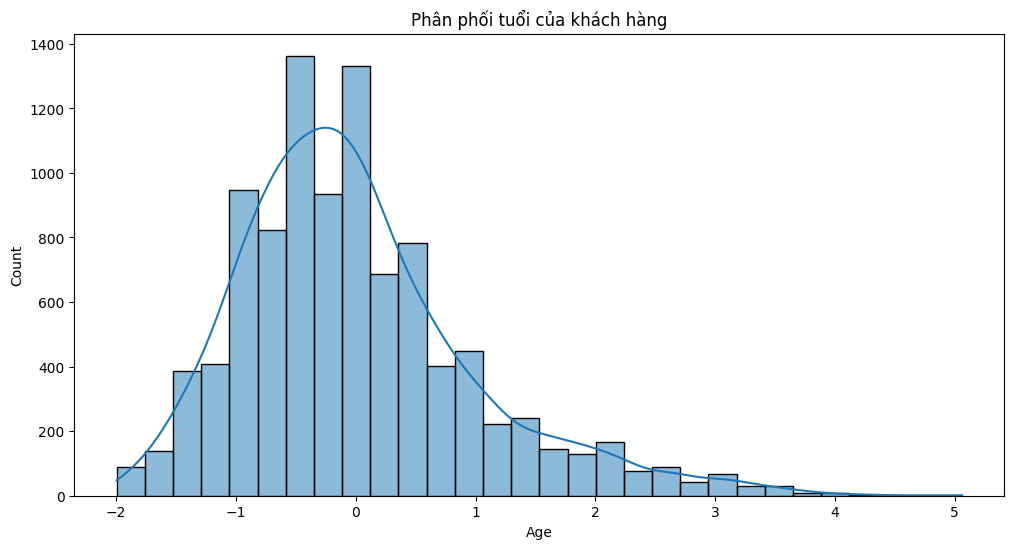

In [41]:
# Vẽ biểu đồ phân phối cho các biến chính
plt.figure(figsize=(12, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Phân phối tuổi của khách hàng')
plt.show()

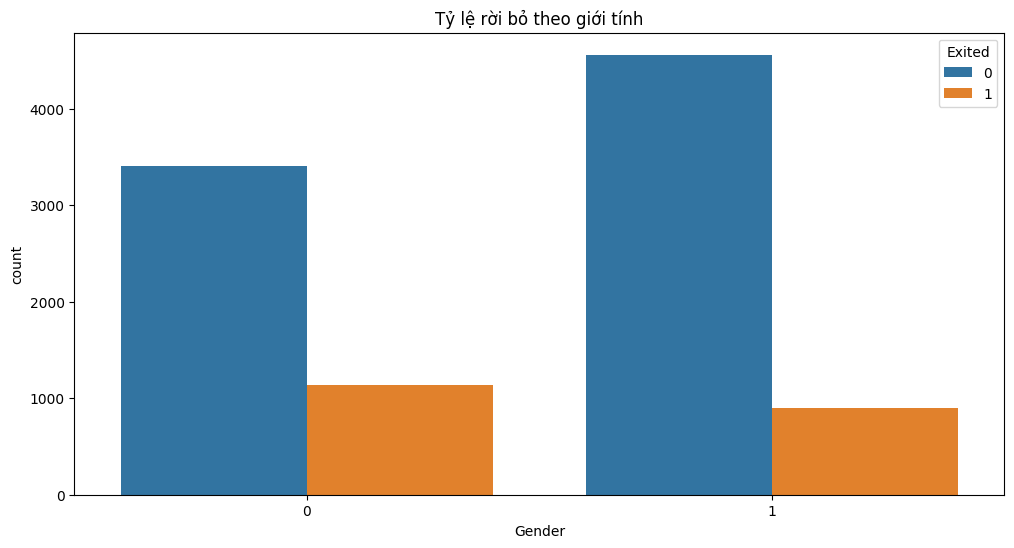

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', hue='Exited', data=data)
plt.title('Tỷ lệ rời bỏ theo giới tính')
plt.show()

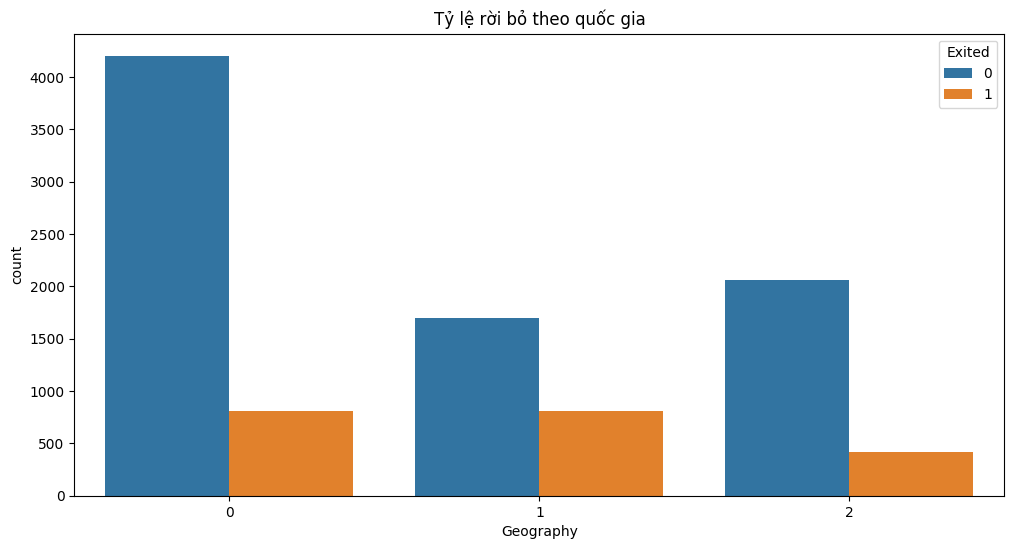

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Geography', hue='Exited', data=data)
plt.title('Tỷ lệ rời bỏ theo quốc gia')
plt.show()

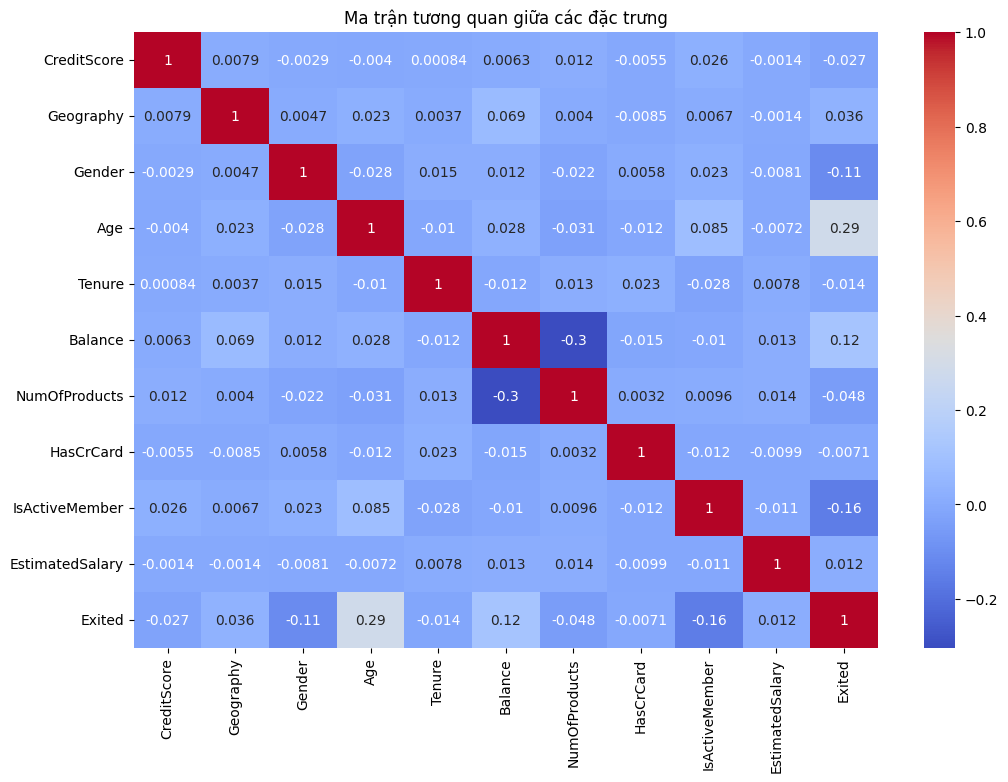

In [44]:
# Ma trận tương quan
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

# 3. SMOTE - Cân bằng dữ liệu

In [45]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
# Áp dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Kiểm tra số lượng mẫu sau khi cân bằng
print(f"Số lượng mẫu trước khi SMOTE: {len(y_train)}")
print(f"Số lượng mẫu sau khi SMOTE: {len(y_train_balanced)}")

Số lượng mẫu trước khi SMOTE: 7000
Số lượng mẫu sau khi SMOTE: 11094


# 4. Modelling and Prediction with Ensemble Methods

### 4.1. Random Forest

In [47]:
# Define the model
rf_model = RandomForestClassifier(random_state=42)

In [48]:
# Huấn luyện và tối ưu hóa mô hình Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_balanced, y_train_balanced)

# Mô hình tốt nhất từ Random Forest
best_rf_model = rf_grid_search.best_estimator_

In [49]:
# Dự đoán với mô hình Random Forest tốt nhất
rf_predictions = best_rf_model.predict(X_test)

# In ra kết quả đánh giá
print("Đánh giá mô hình Random Forest:")
print(classification_report(y_test, rf_predictions))
print(f"Độ chính xác của Random Forest: {accuracy_score(y_test, rf_predictions):.4f}")

Đánh giá mô hình Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2416
           1       0.59      0.60      0.60       584

    accuracy                           0.84      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000

Độ chính xác của Random Forest: 0.8423


### 4.2. GradientBoost

In [50]:
# Huấn luyện và tối ưu hóa mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_train_balanced, y_train_balanced)

# Mô hình tốt nhất từ Gradient Boosting
best_gb_model = gb_grid_search.best_estimator_


In [51]:
# Dự đoán với mô hình Gradient Boosting tốt nhất
gb_predictions = best_gb_model.predict(X_test)

# In ra kết quả đánh giá
print("\nĐánh giá mô hình Gradient Boosting:")
print(classification_report(y_test, gb_predictions))
print(f"Độ chính xác của Gradient Boosting: {accuracy_score(y_test, gb_predictions):.4f}")


Đánh giá mô hình Gradient Boosting:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2416
           1       0.66      0.52      0.58       584

    accuracy                           0.85      3000
   macro avg       0.77      0.73      0.75      3000
weighted avg       0.84      0.85      0.85      3000

Độ chính xác của Gradient Boosting: 0.8540


### 5.3. Voting
- Voting "soft" sẽ dựa trên xác suất của các mô hình thành phần để đưa ra dự đoán cuối cùng. 

In [53]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
# Voting Classifier
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('gb', best_gb_model)
    ],
    voting='soft'  # Sử dụng voting "soft" để tính xác suất của các mô hình thành phần
)

In [54]:
# Huấn luyện mô hình Voting Classifier
voting_ensemble.fit(X_train_balanced, y_train_balanced)

# Dự đoán với Voting Classifier
voting_predictions = voting_ensemble.predict(X_test)

# Đánh giá mô hình Voting Classifier
print("\nĐánh giá mô hình Voting Classifier:")
print(classification_report(y_test, voting_predictions))
print(f"Độ chính xác của Voting Classifier: {accuracy_score(y_test, voting_predictions):.4f}")


Đánh giá mô hình Voting Classifier:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2416
           1       0.66      0.54      0.59       584

    accuracy                           0.86      3000
   macro avg       0.78      0.74      0.75      3000
weighted avg       0.85      0.86      0.85      3000

Độ chính xác của Voting Classifier: 0.8567


### 5.4. Stacking
- Logistic Regression sẽ được sử dụng làm meta model để dự đoán dựa trên các kết quả output của các base model. 

In [55]:
# Stacking Classifier
stacking_ensemble = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('gb', best_gb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),  # Sử dụng Logistic Regression làm mô hình tổng hợp
    cv=5  # 5-fold cross-validation
)

In [56]:
# Huấn luyện mô hình Stacking Classifier
stacking_ensemble.fit(X_train_balanced, y_train_balanced)

# Dự đoán với Stacking Classifier
stacking_predictions = stacking_ensemble.predict(X_test)

# Đánh giá mô hình Stacking Classifier
print("\nĐánh giá mô hình Stacking Classifier:")
print(classification_report(y_test, stacking_predictions))
print(f"Độ chính xác của Stacking Classifier: {accuracy_score(y_test, stacking_predictions):.4f}")


Đánh giá mô hình Stacking Classifier:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2416
           1       0.65      0.57      0.60       584

    accuracy                           0.85      3000
   macro avg       0.77      0.75      0.76      3000
weighted avg       0.85      0.85      0.85      3000

Độ chính xác của Stacking Classifier: 0.8550


# 3. Model Explanation using SHAP

In [ ]:
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test)

# # Plot summary of feature importance
# shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)

# plt.show()